Беспалова Ульяна
Группа ML-11

Тот же файлик на Гитхабе: 

In [ ]:
from google.colab import drive
drive.mount("/content/drive/")

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
%matplotlib inline

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

plt.style.use('seaborn-talk')
plt.rcParams['figure.figsize'] = (15,10)

# Задача про датчики на руках

В этом задании мы применим метод главных компонент на многомерных данных и постараемся найти оптимальную размерность признаков для решения задачи классификации

Исходными [данными](http://archive.ics.uci.edu/ml/machine-learning-databases/auslan2-mld/auslan.data.html) являются показания различных сенсоров, установленных на руках человека, который умеет общаться на языке жестов.

В данном случае задача ставится следующим образом: по показаниям датчиков (по 11 сенсоров на каждую руку) определить слово, которое было показано человеком.

Как можно решать такую задачу?

Показания датчиков представляются в виде временных рядов. Посмотрим на показания для одного из "слов"

In [ ]:
# Загружаем данные сенсоров
df_database = pd.read_csv('./drive/MyDrive/Colab_Notebooks/Technopark_ML/dz_4/data/sign_database.csv')

# Загружаем метки классов
sign_classes = pd.read_csv('./drive/MyDrive/Colab_Notebooks/Technopark_ML/dz_4/data/sign_classes.csv', index_col=0, header=0, names=['id', 'class'])

In [ ]:
# Столбец id - идентификаторы "слов"
# Столбец time - метка времени
# Остальные столбцы - показания серсоров для слова id в момент времени time

df_database.head()

,x_l,x_r,y_l,y_r,z_l,z_r,roll_l,roll_r,pitch_l,pitch_r,yaw_l,yaw_r,thumb_l,thumb_r,forefinger_l,forefinger_r,middle_l,middle_r,ring_l,ring_r,little_l,little_r,id,time
0,-0.097816,-0.127761,-0.029051,0.537977,0.249162,0.508908,0.239445,0.039819,0.0,0.007009,0.019041,0.046011,-0.106124,-0.006852,0.369149,0.381857,0.570995,0.343431,0.0,0.000000,0.0,0.133088,0,0
1,-0.102460,-0.126734,-0.029230,0.537758,0.246477,0.507236,0.240116,0.039057,0.0,0.007009,0.019041,0.047708,-0.050000,-0.009621,0.326618,0.402561,0.595044,0.291571,0.0,0.000000,0.0,0.084865,0,1
2,-0.103085,-0.125618,-0.028605,0.537464,0.244890,0.507273,0.234753,0.039057,0.0,0.007494,0.019041,-0.006363,-0.029461,0.017169,0.295135,0.436131,0.639491,0.242470,0.0,0.000000,0.0,0.026230,0,2
3,-0.102639,-0.126020,-0.028873,0.537306,0.244890,0.507639,0.232072,0.026864,0.0,0.009431,0.019041,-0.085527,-0.003653,0.138081,0.239311,0.521583,0.723905,0.224264,0.0,0.014668,0.0,0.015033,0,3
4,-0.105139,-0.127538,-0.028917,0.537513,0.244816,0.506626,0.234083,0.026864,0.0,0.008947,0.019041,-0.026098,0.100024,0.153798,0.199478,0.675103,0.786566,0.235298,0.0,0.010813,0.0,0.000815,0,4


In [ ]:
sign_classes.head()

,class
id,
0,alive
1,alive
2,alive
3,all
4,all


In [ ]:
# Выберем одно из слов с идентификатором = 0
sign0 = df_database.query('id == 0')\
                   .drop(['id'], axis=1)\
                   .set_index('time')

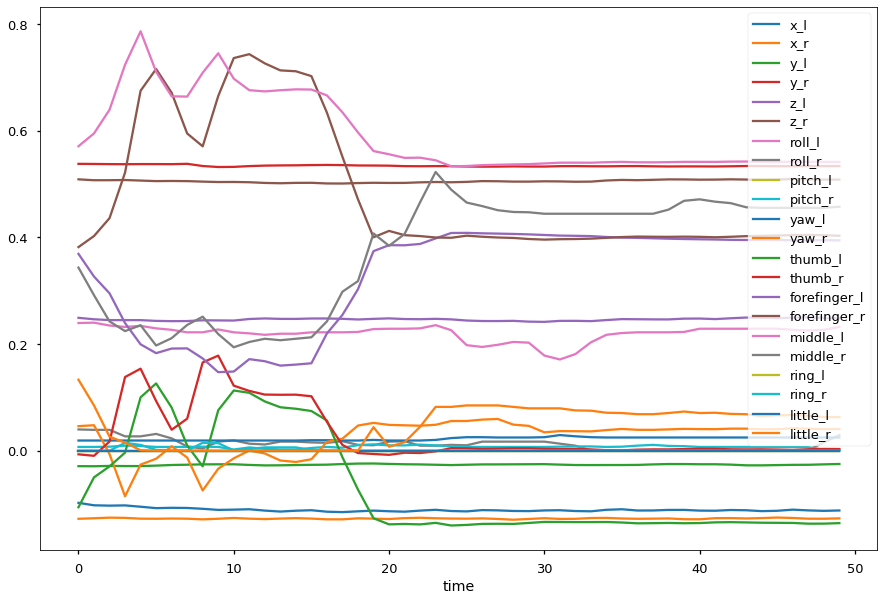

In [ ]:
sign0.plot()

Для каждого из "слов" у нас есть набор показаний сенсоров с разных частей руки в каждый момент времени.

Идея нашего подхода будет заключаться в следующем – давайте для каждого сенсора составим набор характеристик (например, разброс значений, максимальное, минимальное, среднее значение, количество "пиков", и т.п.) и будем использовать эти новые "признаки" для решения задачи классификации.

## Расчет новых признаков

Признаки мы будем считать с помощью библиотеки [tsfresh](http://tsfresh.readthedocs.io/en/latest/index.html). Генерация новых признаков может занять много времени, поэтому мы сохранили посчитанные данные, но при желании вы можете повторить вычисления.

In [ ]:
from sklearn.preprocessing import LabelEncoder

In [ ]:
# Если не хотите долго ждать - не убирайте комментарии
# !pip install tsfresh


# import tsfresh
# from tsfresh.feature_extraction import extract_features
# from tsfresh.feature_selection import select_features
# from tsfresh.utilities.dataframe_functions import impute
# from tsfresh.feature_extraction import ComprehensiveFCParameters, MinimalFCParameters, settings, EfficientFCParameters


# sign_features = extract_features(df_database, column_id='id', column_sort='time',
#                                  default_fc_parameters=EfficientFCParameters(),
#                                  impute_function=impute)

# enc = LabelEncoder()
# enc.fit(sign_classes.loc[:, 'class'])
# sign_classes.loc[:, 'target'] = enc.transform(sign_classes.loc[:, 'class'])

# sign_features_filtered = select_features(sign_features, sign_classes.loc[:, 'target'])

# filepath = './drive/MyDrive/Colab_Notebooks/Technopark_ML/dz_4/data/tsfresh_features_filt.csv.gz'
# sign_features_filtered.to_csv(filepath, compression='gzip')

In [ ]:
# !cd ./drive/MyDrive/Colab_Notebooks/Technopark_ML/dz_4/data
# !wget https://www.dropbox.com/s/x6b9mqxlw5ijcuf/tsfresh_features_filt.csv.gz?dl=0 -O ./drive/MyDrive/Colab_Notebooks/Technopark_ML/dz_4/data/tsfresh_features_filt.csv.gz

In [ ]:
filepath = './drive/MyDrive/Colab_Notebooks/Technopark_ML/dz_4/data/tsfresh_features_filt.csv.gz'
sign_features_filtered = pd.read_csv(filepath)

In [ ]:
sign_features_filtered.shape

(2565, 11517)

In [ ]:
sign_features_filtered.head()

,Unnamed: 0,ring_r__maximum,"ring_r__agg_linear_trend__attr_""intercept""__chunk_len_50__f_agg_""max""","ring_r__agg_linear_trend__attr_""stderr""__chunk_len_5__f_agg_""mean""","ring_r__fft_coefficient__attr_""abs""__coeff_2","ring_r__linear_trend__attr_""stderr""",ring_r__quantile__q_0.9,"ring_r__agg_linear_trend__attr_""stderr""__chunk_len_5__f_agg_""max""",ring_r__variance,ring_r__standard_deviation,"ring_r__agg_linear_trend__attr_""stderr""__chunk_len_10__f_agg_""mean""","ring_r__agg_linear_trend__attr_""stderr""__chunk_len_10__f_agg_""max""","ring_r__agg_linear_trend__attr_""intercept""__chunk_len_10__f_agg_""var""","ring_r__agg_linear_trend__attr_""slope""__chunk_len_10__f_agg_""var""","ring_r__agg_linear_trend__attr_""slope""__chunk_len_5__f_agg_""max""","ring_r__fft_coefficient__attr_""abs""__coeff_1","ring_r__agg_linear_trend__attr_""slope""__chunk_len_10__f_agg_""max""","ring_r__agg_linear_trend__attr_""slope""__chunk_len_50__f_agg_""var""","ring_r__agg_linear_trend__attr_""intercept""__chunk_len_50__f_agg_""var""","little_l__agg_linear_trend__attr_""rvalue""__chunk_len_50__f_agg_""max""","little_l__agg_linear_trend__attr_""rvalue""__chunk_len_50__f_agg_""mean""","little_l__agg_linear_trend__attr_""rvalue""__chunk_len_50__f_agg_""var""","ring_r__fft_coefficient__attr_""imag""__coeff_1","ring_r__change_quantiles__f_agg_""var""__isabs_True__qh_1.0__ql_0.0","ring_r__agg_linear_trend__attr_""stderr""__chunk_len_5__f_agg_""min""","ring_r__agg_linear_trend__attr_""slope""__chunk_len_5__f_agg_""mean""","ring_r__linear_trend__attr_""slope""","ring_r__change_quantiles__f_agg_""var""__isabs_True__qh_1.0__ql_0.4","ring_r__agg_linear_trend__attr_""stderr""__chunk_len_10__f_agg_""var""","ring_r__agg_linear_trend__attr_""slope""__chunk_len_50__f_agg_""max""","ring_r__agg_linear_trend__attr_""slope""__chunk_len_10__f_agg_""mean""",ring_r__cid_ce__normalize_False,"ring_r__cwt_coefficients__coeff_9__w_10__widths_(2, 5, 10, 20)","ring_r__change_quantiles__f_agg_""var""__isabs_True__qh_1.0__ql_0.2","ring_r__cwt_coefficients__coeff_10__w_10__widths_(2, 5, 10, 20)","ring_r__cwt_coefficients__coeff_8__w_10__widths_(2, 5, 10, 20)","ring_r__cwt_coefficients__coeff_11__w_10__widths_(2, 5, 10, 20)","ring_r__change_quantiles__f_agg_""var""__isabs_False__qh_1.0__ql_0.0","ring_r__cwt_coefficients__coeff_7__w_10__widths_(2, 5, 10, 20)","ring_r__agg_linear_trend__attr_""slope""__chunk_len_50__f_agg_""mean""",...,y_r__has_duplicate_max,x_r__large_standard_deviation__r_0.45,x_r__large_standard_deviation__r_0.15000000000000002,yaw_l__symmetry_looking__r_0.25,yaw_l__symmetry_looking__r_0.15000000000000002,roll_r__symmetry_looking__r_0.15000000000000002,roll_r__symmetry_looking__r_0.2,forefinger_r__has_duplicate_min,forefinger_r__symmetry_looking__r_0.05,roll_l__symmetry_looking__r_0.15000000000000002,roll_l__symmetry_looking__r_0.1,forefinger_r__symmetry_looking__r_0.1,forefinger_r__symmetry_looking__r_0.35000000000000003,z_r__large_standard_deviation__r_0.45,forefinger_r__large_standard_deviation__r_0.2,forefinger_r__large_standard_deviation__r_0.45,yaw_r__large_standard_deviation__r_0.4,forefinger_l__has_duplicate_min,thumb_r__large_standard_deviation__r_0.35000000000000003,thumb_r__symmetry_looking__r_0.35000000000000003,thumb_r__symmetry_looking__r_0.30000000000000004,z_r__symmetry_looking__r_0.35000000000000003,forefinger_l__large_standard_deviation__r_0.45,thumb_l__large_standard_deviation__r_0.45,thumb_l__large_standard_deviation__r_0.25,thumb_l__symmetry_looking__r_0.4,thumb_l__symmetry_looking__r_0.1,middle_l__symmetry_looking__r_0.35000000000000003,pitch_l__large_standard_deviation__r_0.45,little_r__symmetry_looking__r_0.2,forefinger_l__large_standard_deviation__r_0.15000000000000002,little_r__symmetry_looking__r_0.15000000000000002,z_l__symmetry_looking__r_0.35000000000000003,roll_r__large_standard_deviation__r_0.25,roll_r__large_standard_deviation__r_0.45,little_r__symmetry_looking__r_0.05,pitch_l__symmetry_looking__r_0.05,z_l__large_stand

## Базовая модель

В результате у нас получилось очень много признаков (11516 или больше), давайте применим метод главных компонент, чтобы получить сжатое признаковое представление, сохранив при этом предиктивную силу в модели.

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

Создадим бейзлайн без уменьшения размерности. Гиперпараметры модели подбирались произвольно

In [ ]:
enc = LabelEncoder()
enc.fit(sign_classes.loc[:, 'class'])
sign_classes.loc[:, 'target'] = enc.transform(sign_classes.loc[:, 'class'])

In [ ]:
# Подготовим данные на вход в модель

# признаки
X = sign_features_filtered.values

# классы
y = sign_classes.target.values

In [ ]:
# Будем делать кросс-валидацию на 5 фолдов
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)

base_model = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', KNeighborsClassifier(n_neighbors=9))
])

base_cv_scores = cross_val_score(base_model, X, y, cv=cv, scoring='accuracy')

In [ ]:
base_cv_scores.mean()

0.9196881091617932

## Метод главных компонент (5 баллов)

* (1) Добавьте в пайплайн `base_model` шаг с методом главных компонент. Начиная с версии 0.18 в sklearn добавили разные солверы для PCA. Дополнитенльно задайте в модели следующие параметры: `svd_solder = "randomized"` и `random_state=123`. Остальные гиперпараметры модели и способ кросс-валидации оставьте без изменений
* (1 + 2) Найдите такое наименьшее количество главных компонент, что качество нового пайплайна превыcит 90%. За +2 бала найдите решение не полным перебором (руками перебрать пару значений, тоже считается полным перебором). Можете считать, что функция зависимости качества от количества компонент монотонно неубывающая. 
* (1) Укажите долю объяснённой дисперсии при найденной настройке PCA  (для этого надо обучить PCA на всех данных). Долю объясненной дисперсии можно найти в атрибуте `explained_variance_ratio`

In [ ]:
# 1) Произвольное число компонент

base_model_pca = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(svd_solver="randomized", random_state=123, n_components=10)),
    ('clf', KNeighborsClassifier(n_neighbors=9))
])

base_cv_scores = cross_val_score(base_model_pca, X, y, cv=cv, scoring='accuracy')

print('n_components=10: ', base_cv_scores.mean())

n_components=10:  0.704093567251462


In [ ]:
# 2) Найдем минимальное n_components, для которого результат будет более 90%

import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
ss = StandardScaler()
X_scaled = ss.fit_transform(X)

In [ ]:
pca = PCA(n_components=200)
pca.fit(X_scaled)

PCA(n_components=200)

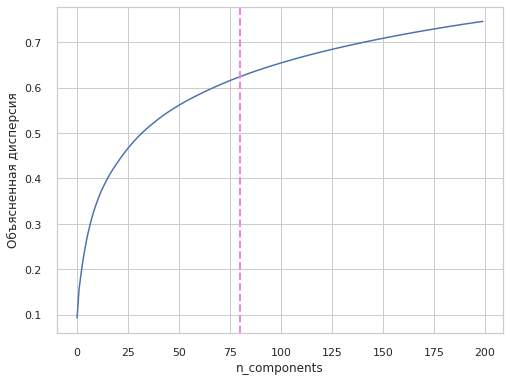

None

In [ ]:
sns.set(style='whitegrid')
fig, pl = plt.subplots()
pl.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('n_components')
plt.ylabel('Объясненная дисперсия')

plt.axvline(linewidth=2, color='violet', linestyle = '--', x=80, ymin=0, ymax=1)
fig.set_figwidth(8)
fig.set_figheight(6)
display(plt.show())

# На графике видим, что объясненная дисперсия перестает значительно расти при n_components≈80. 

In [ ]:
base_model_pca = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(svd_solver="randomized", random_state=123, n_components=80)),
    ('clf', KNeighborsClassifier(n_neighbors=9))
])

base_cv_scores = cross_val_score(base_model_pca, X, y, cv=cv, scoring='accuracy')

print('n_components=80: ', base_cv_scores.mean())

n_components=80:  0.9021442495126706


In [ ]:
evr = pca_test.explained_variance_ratio_
cvr = np.cumsum(pca_test.explained_variance_ratio_)
pca_df = pd.DataFrame()
pca_df['Cumulative Variance Ratio'] = cvr
pca_df['Explained Variance Ratio'] = evr

def _color(val):
  color = 'blue' if 0.623<val and val<0.626 else ''
  return 'color: %s' % color 
pca_df[75:85].style.applymap(_color)

,Cumulative Variance Ratio,Explained Variance Ratio
75,0.615757,0.001837
76,0.617558,0.001800
77,0.619320,0.001762
78,0.621064,0.001744
79,0.622797,0.001732
80,0.624504,0.001707
81,0.626188,0.001683
82,0.627861,0.001673
83,0.629495,0.001634
84,0.631115,0.001620


In [ ]:
# 3) Доля объяснённой дисперсии при n_components=80 составляет 0.624504

# Задача про кластеризацию текстов

Рассмотрим коллекцию новостных сообщений за первую половину 2017 года. Про каждое новостное сообщение известны:
* его заголовок и текст
* дата его публикации
* событие, о котором это новостное сообщение написано 
* его рубрика 

In [ ]:
df = pd.read_csv('./drive/MyDrive/Colab_Notebooks/Technopark_ML/dz_4/data/news.csv', encoding='utf8')
df.head()

,text,date,event,class
0,В ПЕТЕРБУРГЕ ПРОШЕЛ МИТИНГ ПРОТИВ ПЕРЕДАЧИ ИС...,2017-01-10,Передача РПЦ Исаакиевского собора,Внутренняя политика РФ
1,"Lenta.co, Москва, 14 января 2017 СИТУАЦИЯ С П...",2017-01-10,Передача РПЦ Исаакиевского собора,Внутренняя политика РФ
2,"Аргументы и Факты (aif.ru), Москва, 14 января...",2017-01-10,Передача РПЦ Исаакиевского собора,Внутренняя политика РФ
3,"Google Новости ТОП, Москва, 14 января 2017 АК...",2017-01-10,Передача РПЦ Исаакиевского собора,Внутренняя политика РФ
4,"Газета.Ru, Москва, 13 января 2017 В МОСКОВСКО...",2017-01-10,Передача РПЦ Исаакиевского собора,Внутренняя политика РФ


In [ ]:
df.loc[:, 'class'].value_counts()

Важные мировые события                           403
Внутренняя политика РФ                           364
Внутренняя политика РФ: оппозиция                277
Теракты                                          200
Международные отношения                          153
Спорт                                            102
Проишествия  РФ                                  100
Спорт                                            100
Внутренняя политика: культура                    100
Международные отношения: Криминальная хроника     82
Технологии                                        49
Name: class, dtype: int64

In [131]:
true_label = df.loc[:, 'class']

Попробуем кластеризовать документы (каким-либо методом) и сравним полученное разбиение с данными рубликами с помощью ARI

## Стандартная предобработка текстов

Ниже выполняется набор операций по предобработке текстов. Возможно на этом курсе про это не будет идти речь, однако идея довольно простая. Просто следите за комментариями =)

In [ ]:
df.text[0] # Так выглядит первая статья до преобработки

' В ПЕТЕРБУРГЕ ПРОШЕЛ МИТИНГ ПРОТИВ ПЕРЕДАЧИ ИСААКИЕВСКОГО СОБОРА РПЦ В Санкт-Петербурге люди устроили акцию протеста против передачи Исаакиевского собора в безвозмездное пользование РПЦ. Жители Петербурга собрались на Исаакиевской площади, чтобы высказаться против передачи Исаакиевского собора в безвозмездное пользование РПЦ, передает ТАСС. Акция проходит в формате встречи с депутатами Законодательного собрания города и не требует согласования с властями. Участники акции не используют какую-либо символику и плакаты, а также мегафоны или средства звукоусиления. По словам депутата Алексея Ковалева, на Исаакиевскую площадь пришло примерно тысяча человек. Перед участниками протеста выступили депутаты местного парламента Борис Вишневский и Максим Резник, которые заявили о том, что потребуют отмены решения Смольного. Вишневский сообщил, что акция будет проходить в виде встречи депутатов с избирателями. "Закон Санкт-Петербурга предоставляет нам право встречаться с избирателями, такую встречу

In [ ]:
import re

# Оставляем только кириллические символы
regex = re.compile(u"[А-Яа-я]+")

def words_only(text, regex=regex):
    return " ".join(regex.findall(text))

In [ ]:
df.text = df.text.str.lower()
df.loc[:, 'text'] = df.text.apply(words_only)

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
from nltk.corpus import stopwords

# Удаляем стоп-слова
mystopwords = stopwords.words('russian') + ['это', 'наш' , 'тыс', 'млн', 'млрд', u'также',  'т', 'д', '-', '-']

def  remove_stopwords(text, mystopwords = mystopwords):
    try:
        return u" ".join([token for token in text.split() if not token in mystopwords])
    except:
        return u""

In [ ]:
df.text[0]

'в петербурге прошел митинг против передачи исаакиевского собора рпц в санкт петербурге люди устроили акцию протеста против передачи исаакиевского собора в безвозмездное пользование рпц жители петербурга собрались на исаакиевской площади чтобы высказаться против передачи исаакиевского собора в безвозмездное пользование рпц передает тасс акция проходит в формате встречи с депутатами законодательного собрания города и не требует согласования с властями участники акции не используют какую либо символику и плакаты а также мегафоны или средства звукоусиления по словам депутата алексея ковалева на исаакиевскую площадь пришло примерно тысяча человек перед участниками протеста выступили депутаты местного парламента борис вишневский и максим резник которые заявили о том что потребуют отмены решения смольного вишневский сообщил что акция будет проходить в виде встречи депутатов с избирателями закон санкт петербурга предоставляет нам право встречаться с избирателями такую встречу мы и проведем ра

In [ ]:
# !pip install pymystem3
!wget http://download.cdn.yandex.net/mystem/mystem-3.0-linux3.1-64bit.tar.gz
!tar -xvf mystem-3.0-linux3.1-64bit.tar.gz
!mv ./mystem ./drive/MyDrive/Colab_Notebooks/Technopark_ML/dz_4

In [36]:
!sudo chmod 777 ./drive/MyDrive/Colab_Notebooks/Technopark_ML/dz_4/mystem

In [41]:
%%time 
from pymystem3 import Mystem

# нормализуем текст
bin_path = "./drive/MyDrive/Colab_Notebooks/Technopark_ML/dz_4/mystem"
m = Mystem(bin_path)
def lemmatize(text, mystem=m):
    try:
        return "".join(m.lemmatize(text)).strip()  
    except:
        return " ! "

CPU times: user 35 µs, sys: 0 ns, total: 35 µs
Wall time: 38.9 µs


In [42]:
df.text = df.text.apply(lemmatize)

In [44]:
mystoplemmas = [u'который', u'прошлый', u'сей', u'свой', u'наш', u'мочь']

# Еще кое-что удаляем
def  remove_stoplemmas(text, mystoplemmas = mystoplemmas):
    try:
        return " ".join([token for token in text.split() if not token in mystoplemmas])
    except:
        return ""

df.text = df.text.apply(remove_stoplemmas)  

In [45]:
df.text[3] # так выгладит третья статья после предобработки

'москва январь ситуация с передача исаакиевский собор в ведение рпц история собор читать оригинал публикация на ссылка на видео считать храм исаакиевский собор невероятный творение огюст монферран быть отныне много основание губернатор петербург и патриарх московский и весь русь договариваться о то что собор принадлежать город быть передавать русский православный церковь об это губернатор георгий полтавченко сообщать в начало этот неделя разговор о передача собор рпц идти давно но этот новость все равный производить сильный эффект пара сотня противник решение даже выходить вчера на митинг у собор а чуть поодаль в тот же минута митинговать за один из самый обсуждать вопрос сохранять ли исаакиевский музей прежний возможность в его новый статус после передача он в безвозмездный пользование церковь вопрос финансирование тоже приходиться решать заново в рпц заявлять что не исключать получение от город субсидия на содержание здание потом появляться версия о передача собор только лишь на опре

## Вычисление сходства (1 балл)

С помощью `TfidfVectorizer` и `pairwise_distances` расчитайте **косинусное** расстояние между всеми парами документов к корпусе.

Про векторизацию текстов с помощью `CountVectorizer` или `TfidfVectorizer` можно почитать [тут](https://www.machinelearningmastery.ru/gentle-introduction-bag-words-model/) 

Запишите результат в переменную `S`

In [46]:
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import pairwise_distances

In [47]:
vect = TfidfVectorizer()
texts = df.text.values

In [81]:
len(texts)

1930

In [82]:
matrix = vect.fit_transform(texts)

vecs = np.asarray(matrix.todense())
vecs.shape

(1930, 22786)

In [88]:
S = pairwise_distances(vecs, metric='cosine')
S.shape

(1930, 1930)

[[], []]

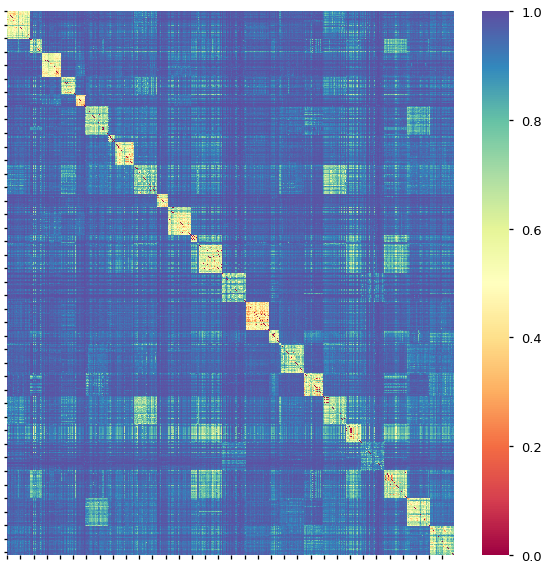

In [90]:
plt.figure(figsize = (10,10))
sns.heatmap(data=S, cmap = 'Spectral').set(xticklabels=[],yticklabels=[])


Вы должны пронаблюдать, что между некоторыми текстами есть довольно высокое сходство по содержанию слов - мы видим, что вдоль диагонали матрицы попарых расстояний есть "блоки" по похожести. 

Нам конечно же повезло, так как тексты заранее были удачно упорядочены. В реальности такой живописной картины мы скорее всего не увидим.

Попробуем их кластеризовать

## DBSCAN (4 балла)
* (2) Воспользуйтесь методикой оценки параметров для алгоритма DBSCAN. Не копипастите `min_pts = 2` из семинара! Используйте **косинусную** меру близости.
* (1) Выделите кластеры. Для каждого кластера (кроме -1, если он будет) выведите несколько текстов и умозрительно определите его тематику. Можете подсмотреть в исходные тематики корпуса
* (1) Оцените сходство с изначальными рубриками визуально (с помощью матрицы перемешивания) и с помощью [Adjusted Rand Index](https://en.wikipedia.org/wiki/Rand_index)

In [364]:
# 1) Согласно карте схожести, размер самого маленького "блока" похожих элементов составляет 10-15 штучек
# Примем min_pts = 10

In [113]:
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN

In [321]:
# Определим наиболее подходящее значение eps 

min_pts = 10
nn = NearestNeighbors(n_neighbors = min_pts, metric='cosine')
nn.fit(vecs)

NearestNeighbors(metric='cosine', n_neighbors=10)

In [322]:
dist, _ = nn.kneighbors(vecs)

In [323]:
dist_last = dist[:, -1]
dist_last = np.sort(dist_last)

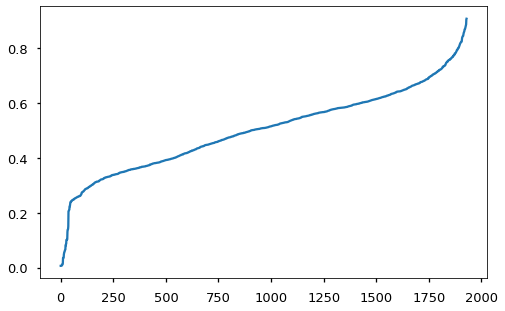

In [324]:
plt.figure(figsize = (8,5))
plt.plot(dist_last)

In [365]:
# Примем eps = 0.6

In [366]:
clustering = DBSCAN(eps = 0.6, min_samples=min_pts, metric='cosine').fit(vecs)

In [367]:
labels = clustering.labels_
len(set(labels))

14

In [374]:
# 2) Попробуем интерпретировать полученные кластеры

In [375]:
df_clasters = pd.concat([df, pd.DataFrame(labels, columns=["dbscan_labels"])], axis=1)

In [417]:
# label 0
df_clasters[df_clasters.dbscan_labels==0].text[:5]

# Выглядит как внутренняя политика и оппозиция

0    в петербург проходить митинг против передача и...
1    москва январь ситуация с передача исаакиевский...
2    аргумент и факт москва январь оппозиция провод...
3    новость топ москва январь акция против передач...
4    газета москва январь в московский патриархия п...
Name: text, dtype: object

In [387]:
# label 1
df_clasters[df_clasters.dbscan_labels==1].text[:5]

# Узнала, что такое инаугурация. Вполне похоже на внешнюю политику

100    инаугурация го президент сша дональд трамп в п...
102    москва январь трамп подписывать первый докумен...
103    дэлайт новость москва январь инаугурация трамп...
104    дэлайт новость москва январь инаугурация трамп...
105    дэлайт новость москва январь инаугурация трамп...
Name: text, dtype: object

In [386]:
# label 2
df_clasters[df_clasters.dbscan_labels==2].text[:5]

# Какие-то перемешанные темы внутренней и внешней политики

110    москва январь первый речь трамп на пост презид...
115    москва январь речь трамп быть в дух рейган и к...
124    весть экономика москва январь речь трамп быть ...
125    москва январь речь трамп быть в дух рейган и к...
138    прайм золото москва январь обзор публикация в ...
Name: text, dtype: object

In [391]:
# label 3
df_clasters[df_clasters.dbscan_labels==3].text[:5]

# Смерть дипломата тянет на мировые события или внешнюю политику

151    умирать виталий чуркин постоянный представител...
152    москва февраль москвич нести цветок к здание м...
153    москва февраль путин посмертно награждать чурк...
154    москва февраль москвич нести цветок к здание м...
155    москва февраль неожиданный смерть мид рф быть ...
Name: text, dtype: object

In [393]:
# label 4
df_clasters[df_clasters.dbscan_labels==4].text[:5]

# Вот это точно мировые события

299    восемь сердце рокфеллер скончаться миллиардер ...
300    геополитика москва март умирать дэвид рокфелле...
301    москва март умирать дэвид рокфеллер факт жизнь...
302    сми москва март на м год жизнь умирать старый ...
303    москва март о то как умирать дэвид рокфеллер м...
Name: text, dtype: object

In [395]:
# label 5
df_clasters[df_clasters.dbscan_labels==5].text[:5]

# А это точно теракты

343    новость день москва март теракт в лондон март ...
344    москва март устраивать теракт в лондон бородач...
345    москва март теракт в лондон новый подробность ...
346    москва март теракт в лондон новый подробность ...
347    весть москва март доморощенный терроризм атака...
Name: text, dtype: object

In [398]:
# label 6
df_clasters[df_clasters.dbscan_labels==6].text[:7]

# Криминальная хроника, тоже несложно

467    в упор и рикошет автор польгуев екатерина выст...
471    русый инфо москва март в киев застреливать быв...
472    москва март в киев застреливать бывший депутат...
473    москва март павел паршов что известно об убийц...
474    русый инфо москва март враг россия ликвидирова...
475    москва март павел паршов что известно об убийц...
476    москва март павел паршов что известно об убийц...
Name: text, dtype: object

In [404]:
# label 7
df_clasters[df_clasters.dbscan_labels==7].text[:5]

# Либо мировые события, либо технологии

649    рогозин поздравлять илона маска с удачный запу...
650    яндекс новость москва март проводить повторный...
651    яндекс новость москва март рогозин поздравлять...
652    москва март производить ый в история повторный...
653    серебряный дождь москва март дмитрий рогозин п...
Name: text, dtype: object

In [407]:
# label 8
df_clasters[df_clasters.dbscan_labels==8].text[:5]

# Точно спорт

931    тасс москва май команда россия и сша разыгрыва...
932    риа новость москва май выходить в плей офф сбо...
933    известие москва май в кельн за медаль автор ал...
934    тасс москва май очередной испытание команда зн...
935    тасс москва май плохой лед и золушка из латвия...
Name: text, dtype: object

In [409]:
# label 9
df_clasters[df_clasters.dbscan_labels==9].text[:5]

# Определенно внутренняя политика

1033    турист скидываться по рубль за крым автор фаля...
1034    яндекс новость москва май в дума вносить закон...
1035    москва май правительство вносить в госдума зак...
1036    москва май в госдума вносить законопроект о ку...
1037    москва май в госдума вносить законопроект о ку...
Name: text, dtype: object

In [411]:
# label 10
df_clasters[df_clasters.dbscan_labels==10].text[:5]

# Международные отношения или мировые события

1133    сми прогнозировать столкновение макрон с трамп...
1134    москва май макрон побеждать на президентский в...
1135    москва май юнкер заявлять что быть счастливый ...
1136    новость москва май юнкер заявлять что быть сча...
1137    риа новость москва май юнкер заявлять что быть...
Name: text, dtype: object

In [414]:
# label 11
df_clasters[df_clasters.dbscan_labels==11].text[:5]

# Проишествия  РФ

1186    жертва ураган в москва список компенсация ураг...
1187    институт религия и политика москва май в резул...
1188    москва май увеличиваться количество пострадавш...
1189    поливать грамота москва май жертва ураган в мо...
1190    москва май ск рф сообщать новый сведение о пог...
Name: text, dtype: object

In [416]:
# label 12
df_clasters[df_clasters.dbscan_labels==12].text[:5]

# Внутренняя политика

1830    выборы без сюрприз эксперт называть явка в еди...
1831    коммерсант москва сентябрь единообразный день ...
1832    риа новость москва сентябрь явка на выборы в м...
1833    риа новость москва сентябрь единый день голосо...
1834    риа новость москва сентябрь россиянин выбирать...
Name: text, dtype: object

In [422]:
# Оно даже интерпретируется
# По крайней мере, элементы внутри кластера похожи
# А вот с отделением кластеров друг от друга всё не очень

In [423]:
# 3) Сравнение с правильными значениями

# Больше всего проблем с разграничением важных мировых событий и внутренней политики
# (Справедливости ради, я тоже их путаю)
# Зато неплохо справились с разделением более конкретных тем вроде террактов и культуры.

In [362]:
pd.crosstab(df.loc[:, 'class'], labels)

col_0,-1,0,1,2,3,4,5,6,7,8,9,10,11,12
class,,,,,,,,,,,,,,
Важные мировые события,25,0,28,102,84,41,0,0,0,0,0,123,0,0
Внутренняя политика РФ,14,99,0,62,0,0,0,0,0,0,100,0,0,89
Внутренняя политика РФ: оппозиция,58,0,0,219,0,0,0,0,0,0,0,0,0,0
Внутренняя политика: культура,2,0,0,98,0,0,0,0,0,0,0,0,0,0
Международные отношения,2,0,0,151,0,0,0,0,0,0,0,0,0,0
Международные отношения: Криминальная хроника,4,0,0,0,0,0,0,78,0,0,0,0,0,0
Проишествия РФ,2,0,0,0,0,0,0,0,0,0,0,0,98,0
Спорт,98,0,0,2,0,0,0,0,0,0,0,0,0,0
Спорт,29,0,0,0,0,0,0,0,0,73,0,0,0,0


In [363]:
from sklearn.metrics import adjusted_rand_score
adjusted_rand_score(true_label, labels)

0.31814171115894363